In [1]:
suppressPackageStartupMessages({
    library(ggplot2)
    library(reshape2)
    library(tibble)
    library(dplyr)
})

theme_set(theme_minimal())
theme_update(text = element_text(size = 17))

In [2]:
anno_pep = read.table("../data/PhageScan_PeptideAnno.tsv", header = TRUE, sep = "\t", stringsAsFactors=FALSE)
lhfc = read.table("../data/PhageScan_peptide_logHFC.csv", sep = ",")

In [3]:
peps = anno_pep[anno_pep$containsResSite==FALSE ,c("tile_id","pro_id","taxon_id","sublibrary")]
lhfc[peps$tile_id,] %>% rowSums()>0 -> peptide_fair_groundtruth
peps = cbind(peps,reactive = as.numeric(peptide_fair_groundtruth))
peps = droplevels(peps)

## Question

Do we get a good recall per base probed?

In [4]:
merge(aggregate(tile_id ~ sublibrary + reactive, data = peps, FUN = length), 
      aggregate(tile_id ~ sublibrary, data = peps, FUN = length), 
      by = "sublibrary", all = TRUE) %>% 
rename(total_peptides = tile_id.y) %>% rename(react_peptides = tile_id.x) %>% 
mutate(ratio = react_peptides/total_peptides) -> evaldf

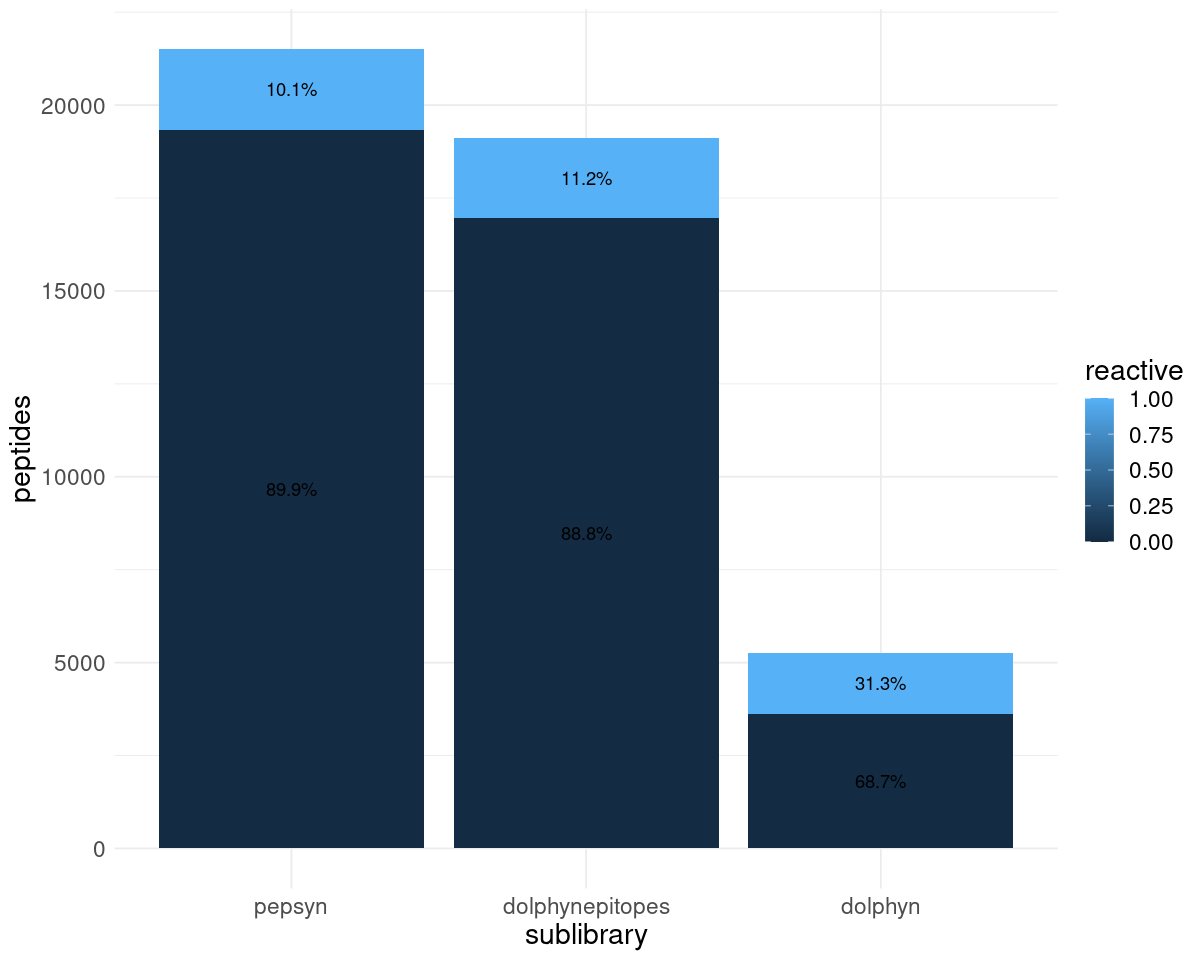

In [5]:
options(repr.plot.width=10, repr.plot.height=8)

evaldf %>% select(-total_peptides) %>% rename(peptides = react_peptides) %>%
mutate(sublibrary = factor(sublibrary, levels = c("pepsyn", "dolphynepitopes", "dolphyn"))) %>%
ggplot(aes(fill=reactive, y=peptides, x=sublibrary)) + 
    geom_bar(position=position_stack(reverse = FALSE), stat="identity") +    
    geom_text(aes(label=paste0(sprintf("%1.1f", 100 * ratio),"%")), position=position_stack(vjust=0.5)) 

## Question

Whats the recall/discovery power per protein/phage?

In [6]:
options(repr.plot.width=10, repr.plot.height=8)

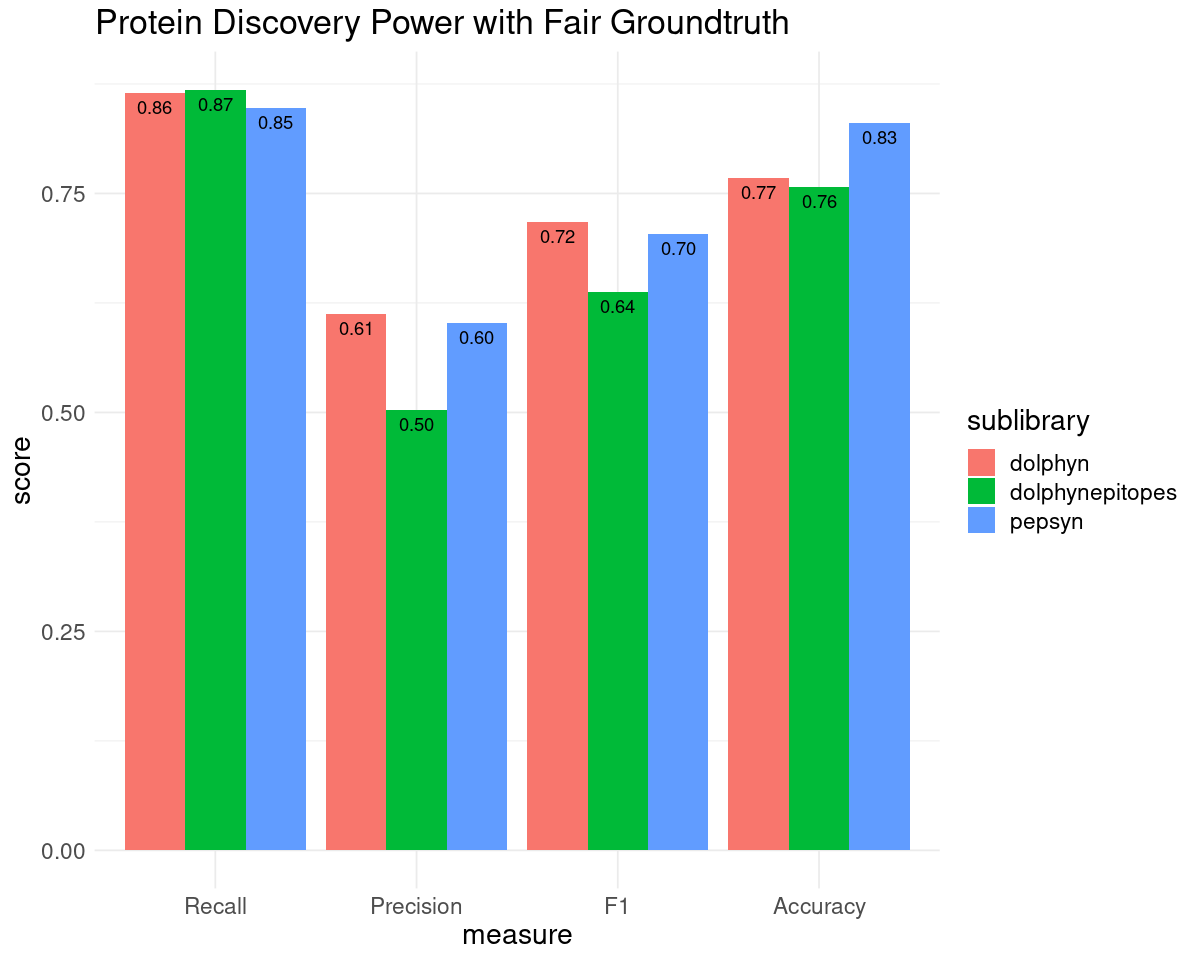

In [7]:
peps %>% aggregate(reactive ~ pro_id, data = ., FUN = sum) %>% mutate(protein_grountruth = as.numeric(reactive > 2)) %>% select(-reactive) ->> protein_truth
peps %>% aggregate(reactive ~ pro_id + sublibrary, data = ., FUN = max) %>% merge(protein_truth, by = "pro_id") -> protein_df

protein_df %>% subset(protein_grountruth == 1) %>% select(sublibrary, reactive) %>% 
table() %>% as.data.frame() %>% dcast(sublibrary ~ reactive, value.var = "Freq") %>% rename(FN="0",TP="1") %>%
mutate(Recall = TP/(TP+FN)) -> recall_df

protein_df %>% subset(reactive == 1) %>% select(sublibrary, protein_grountruth) %>% 
table() %>% as.data.frame() %>% dcast(sublibrary ~ protein_grountruth, value.var = "Freq") %>% rename(FP="0",TP="1") %>%
mutate(Precision = TP/(TP+FP)) -> prec_df

protein_df %>% subset(reactive == 0) %>% subset(protein_grountruth == 0)  %>% select(sublibrary) %>% 
table() %>% as.data.frame() %>% rename(sublibrary=".",TN="Freq") -> tn_df

merge(recall_df,prec_df) %>% merge(tn_df) %>% 
mutate(F1=2*Precision*Recall/(Precision+Recall)) %>% 
mutate(Accuracy=(TP+TN)/(TP+FN+TN+FP)) -> score_df

score_df %>% select(-TP,-FN,-TN,-FP) %>% 
melt(id.vars = "sublibrary", variable.name="measure", value.name="score") %>%
ggplot(aes(x=measure,y=score,fill = sublibrary)) + geom_bar(position="dodge",stat="identity") + 
geom_text(aes(label=paste0(sprintf("%1.2f", score))), vjust = 1.5, position=position_dodge(.9)) +
ggtitle("Protein Discovery Power with Fair Groundtruth")

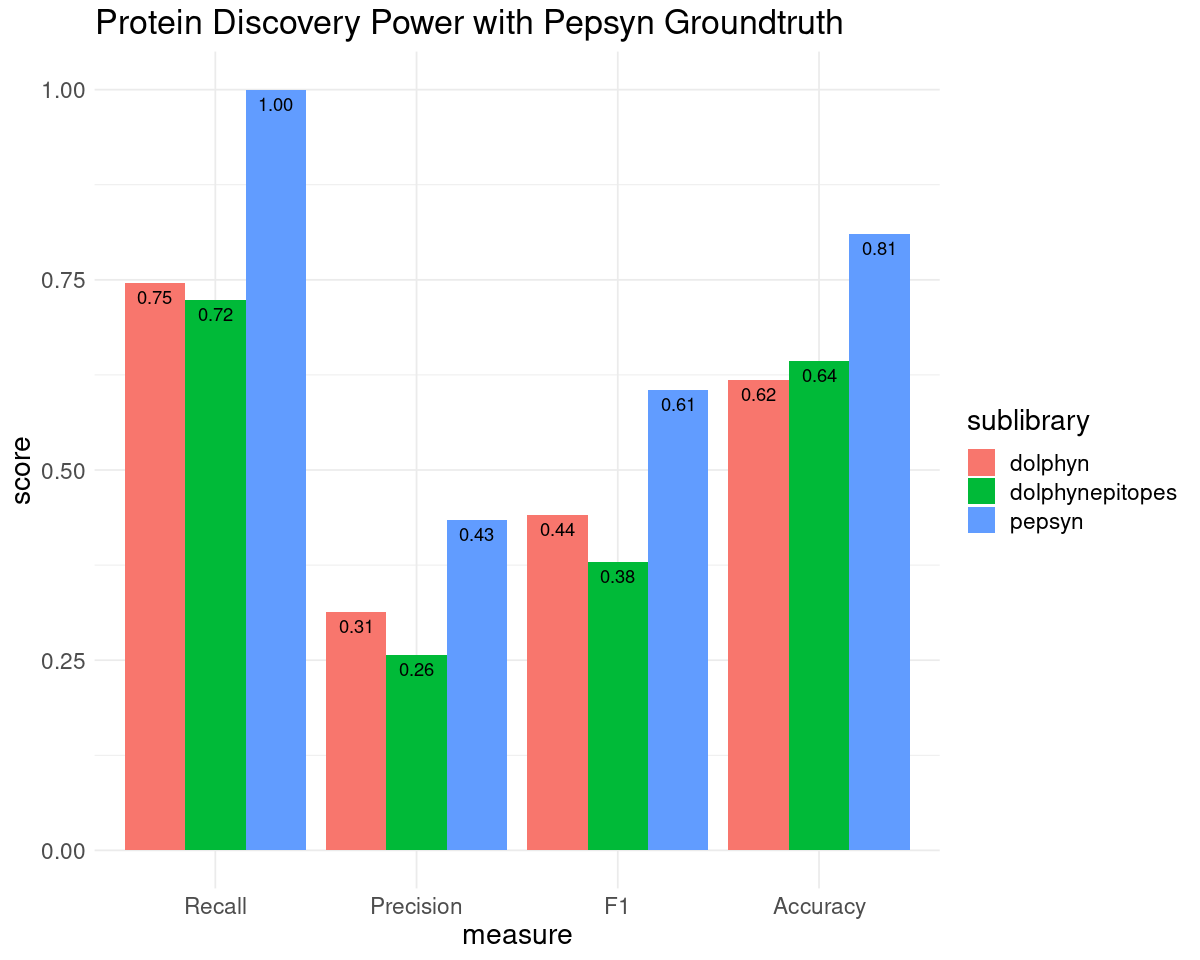

In [8]:
peps %>% subset(sublibrary=="pepsyn") %>% aggregate(reactive ~ pro_id, data = ., FUN = sum) %>% mutate(protein_grountruth = as.numeric(reactive > 1)) %>% select(-reactive) ->> pepsyn_protein_truth
peps %>% aggregate(reactive ~ pro_id + sublibrary, data = ., FUN = max) %>% merge(pepsyn_protein_truth, by = "pro_id") -> protein_df

protein_df %>% subset(protein_grountruth == 1) %>% select(sublibrary, reactive) %>% 
table() %>% as.data.frame() %>% dcast(sublibrary ~ reactive, value.var = "Freq") %>% rename(FN="0",TP="1") %>%
mutate(Recall = TP/(TP+FN)) -> recall_df

protein_df %>% subset(reactive == 1) %>% select(sublibrary, protein_grountruth) %>% 
table() %>% as.data.frame() %>% dcast(sublibrary ~ protein_grountruth, value.var = "Freq") %>% rename(FP="0",TP="1") %>%
mutate(Precision = TP/(TP+FP)) -> prec_df

protein_df %>% subset(reactive == 0) %>% subset(protein_grountruth == 0)  %>% select(sublibrary) %>% 
table() %>% as.data.frame() %>% rename(sublibrary=".",TN="Freq") -> tn_df

merge(recall_df,prec_df) %>% merge(tn_df) %>% 
mutate(F1=2*Precision*Recall/(Precision+Recall)) %>% 
mutate(Accuracy=(TP+TN)/(TP+FN+TN+FP)) -> score_df

score_df %>% select(-TP,-FN,-TN,-FP) %>% 
melt(id.vars = "sublibrary", variable.name="measure", value.name="score") %>%
ggplot(aes(x=measure,y=score,fill = sublibrary)) + geom_bar(position="dodge",stat="identity") + 
geom_text(aes(label=paste0(sprintf("%1.2f", score))), vjust = 1.5, position=position_dodge(.9)) +
ggtitle("Protein Discovery Power with Pepsyn Groundtruth")

# Question
curve, based on pepsyn groundtruth, AA vs reactivity

In [9]:
merge(anno_pep %>% subset(containsResSite==FALSE) %>% select(sublibrary, pro_id, tile_id, RFproba, RFproba_mean),
      rowSums(lhfc>0), by.x = "tile_id", by.y="row.names") -> peps

peps %>% subset(sublibrary == "pepsyn") %>% 
aggregate(y ~ pro_id, data = ., FUN = max) %>% 
mutate(pepsyn_reactive_protein = as.numeric(y>0)) %>% select(-y) %>% 
merge(peps) -> peps

anno_pep %>% subset(containsResSite==FALSE) %>% select(tile_id,pro_id,sublibrary) %>%
merge(lhfc %>% rownames_to_column("tile_id")) %>% 
melt(id.vars = c("tile_id","pro_id","sublibrary"), value.name = "lhfc", variable.name = "sample") %>% 
mutate(reactive = as.numeric(lhfc >0)) %>%
mutate(samplePro = paste(pro_id,sample)) %>% select(-lhfc) -> sample_protein_bin
sample_protein_bin %>% subset(sublibrary == "pepsyn") %>% 
aggregate(reactive ~ samplePro, data = ., FUN = max) %>%
rename(samplePro_reactiveinPepsyn = reactive) %>% merge(sample_protein_bin) %>%
mutate(sample_hitPepsyn = samplePro_reactiveinPepsyn*reactive) %>%
aggregate(sample_hitPepsyn ~ tile_id, data = ., FUN = sum) -> sample_hitPepsyn_peptides

merge(peps,sample_hitPepsyn_peptides) -> peps

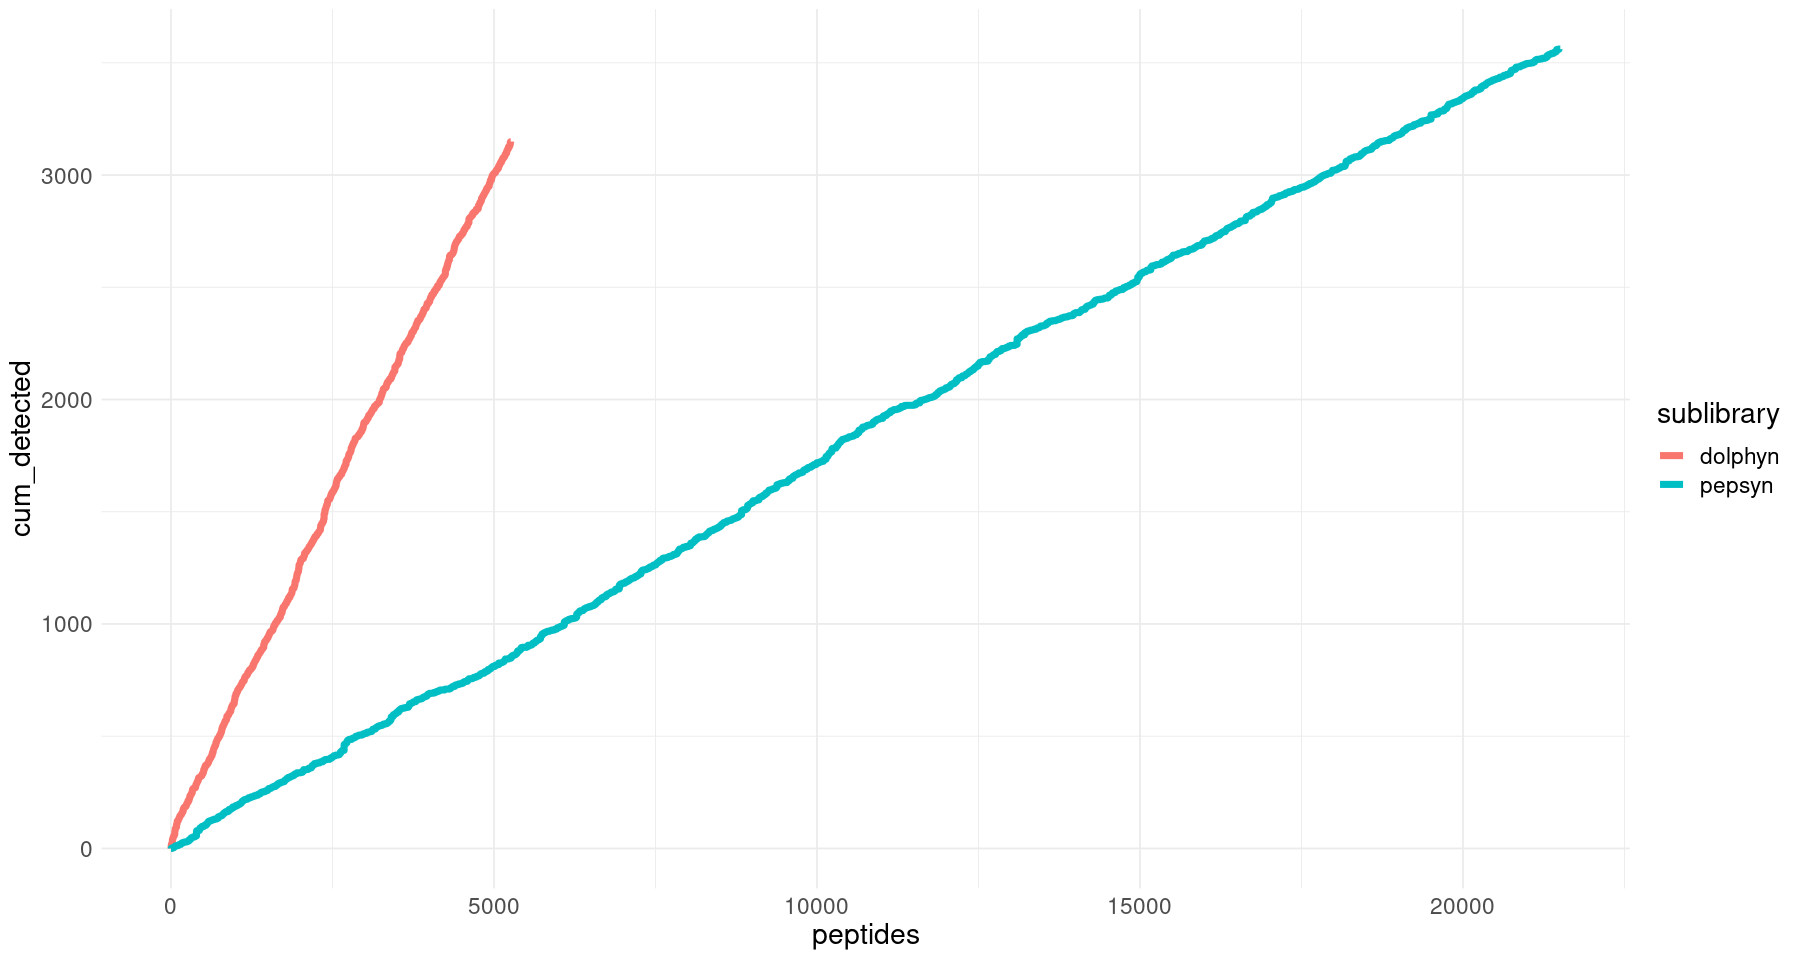

In [10]:
options(repr.plot.width=15, repr.plot.height=8)

peps %>% sample_frac(1L) %>% 
arrange(desc(RFproba_mean)) %>% 
subset(sublibrary != "dolphynepitopes") %>%
group_by(sublibrary) %>% mutate(peptides = row_number()) %>%
mutate(cum_detected = cumsum(y)) %>%
mutate(cum_detected_ifPepsyn = cumsum(y*pepsyn_reactive_protein)) %>%
mutate(cum_detected_ifSampleNPepsyn = cumsum(sample_hitPepsyn)) %>%
#subset(order<5000) %>% #zoom
ungroup() %>%
mutate(perAA = case_when(sublibrary=="dolphynepitopes" ~ peptides*15,
                         sublibrary=="dolphyn" ~ peptides*56,
                         sublibrary=="pepsyn" ~ peptides*56)) %>%
ggplot(aes(x=peptides, y = cum_detected, color = sublibrary)) + geom_step(size=2) 